# Explain CNN using Saliency Map

In [1]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
import matplotlib.pyplot as plt
import keras

https://github.com/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb

In [2]:
batch_size = 128
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 1100 images belonging to 2 classes.
Found 380 images belonging to 2 classes.


In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', name='preds'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [4]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 175232)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                11214912  
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

In [5]:
model.fit(train_generator,
                    steps_per_epoch=1100 // batch_size,
                    epochs=3,
                    validation_data=validation_generator,
                    validation_steps=380 // batch_size)

Epoch 1/3
8/8 [==============================] - 14s 2s/step - loss: 4.5939 - accuracy: 0.7119 - val_loss: 0.0403 - val_accuracy: 0.9961
Epoch 2/3
8/8 [==============================] - 18s 2s/step - loss: 0.1574 - accuracy: 0.9660 - val_loss: 0.0543 - val_accuracy: 0.9961
Epoch 3/3
8/8 [==============================] - 11s 1s/step - loss: 0.0578 - accuracy: 0.9856 - val_loss: 8.6266e-06 - val_accuracy: 1.0000


In [6]:
y_pred = model.predict(validation_generator)

In [7]:
print(y_pred.shape)

(380, 1)


In [8]:
y_pred[0]

array([0.9999818], dtype=float32)

### Open Question

Can we trust this model? Should we use this model to classify digimon and pokemon?

In [9]:
validation_generator.reset()
x,y = validation_generator.next()
# Select several images: two from pokemon and two from digimon
img_data_digi = []
img_data_poke = []


num_batch = 400 // batch_size

for _ in range(0,num_batch):
    for idx in range(len(x)):
        image = x[idx]
        if y[idx] == 0:
            img_data_digi.append(image)
        if y[idx] == 1:
            img_data_poke.append(image)
    x,y = validation_generator.next()

In [10]:
import random
random.seed(2202)

In [11]:
sampled_img = random.sample(img_data_digi, 3) + random.sample(img_data_poke, 3)

In [12]:
len(sampled_img)

6

In [13]:
import numpy as np
img_data = np.asarray(sampled_img)
labelnames = ['digimon','pokemon']
img_titlesidx = [0,0,0,1,1,1]
img_titles = [labelnames[ele] for ele in img_titlesidx]

In [14]:
def loss(output):
    return output

In [15]:
import numpy as np
print(img_data.shape)

(6, 150, 150, 3)


In [16]:
# Rendering
subplot_args = { 'nrows': 2, 'ncols': 3, 'figsize': (18, 6),
                 'subplot_kw': {'xticks': [], 'yticks': []} }

## Gradient-based Method

In the following, we will use a saliency map algorithm that helps us better understand deep learning models' prediction. 

Install tf-keras-vis: https://github.com/keisen/tf-keras-vis

Through those approaches, saliency maps are usually generated as a heatmap (see: map), where hotness corresponds to regions that have a big impact on the model’s final decision (see: saliency).

In [17]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

#### Vanilla Saliency

The method was proposed in this paper: [Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps](https://arxiv.org/pdf/1312.6034.pdf).

* It is the simplest algorithm among gradient-based approaches and very fast to run
* Vanilla Gradient has been shown to be relatively robust.

Vanilla Gradient algorithm works as follow:

1. forward pass with data
2. backward pass to input layer to get the gradient
3. render the gradient as a normalized heatmap



#### Create Saliency object.

In [18]:
def model_modifier(m):
    m.layers[-1].activation = keras.activations.linear
    return m

In [19]:
# Create Saliency object.
# If `clone` is True(default), the `model` will be cloned,
# so the `model` instance will be NOT modified, but it takes a machine resources.
saliency = Saliency(model,
                    model_modifier=model_modifier,
                    clone=False)

#### Generate saliency map with smoothing

In [20]:
saliency_map = saliency(loss,
                        img_data,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.
saliency_map = normalize(saliency_map)

#### Render Saliency Map

1. blue indicats low attention
2. red means high attention 
3. attention is the input contribution to output

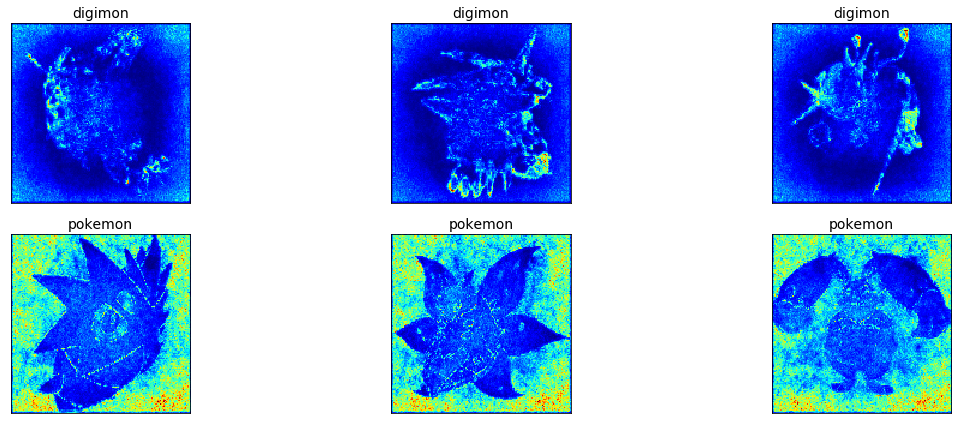

In [21]:
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(img_titles):
    row_idx = int(i / 3)
    col_idx = i % 3
    ax[row_idx, col_idx].set_title(title, fontsize=14)
    ax[row_idx, col_idx].imshow(saliency_map[i], cmap='jet')
plt.tight_layout()
plt.show()

### Where is the high attention region? 

The corner of the images instead of the center parts

After further check, we found: 

1. PNG loaded by Keras appears fully black

2. CNN only learns to classify pokemon and digimon based on background colors.


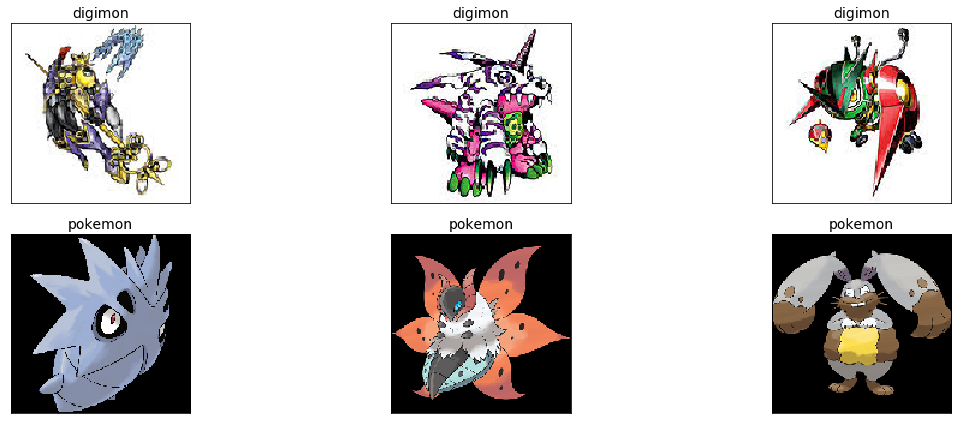

In [22]:
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(img_titles):
    row_idx = int(i / 3)
    col_idx = i % 3
    ax[row_idx, col_idx].set_title(title, fontsize=14)
    ax[row_idx, col_idx].imshow(img_data[i])
plt.tight_layout()
plt.show()